In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ortools

In [ ]:
import requests
from scipy.spatial import distance_matrix
import os
import base64
import cv2
import time
import re

In [ ]:

def plot_mtsp_routes(points, routes_dict, routes_plot_filename):
    """Plot the routes and points for the mTSP problem."""
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plot points and routes
    plt.figure(figsize=(8, 8))

    # Plot all points in red except the depot
    for idx, (x, y) in enumerate(points):
        if idx == 0:
            plt.plot(x, y, 'ks', markersize=10)  # Depot
        else:
            plt.plot(x, y, 'ro')
        plt.text(x, y, str(idx), fontsize=12, ha='right')

    # Plot routes
    for route in routes_dict.values():
        route_points = [points[node] for node in route]
        route_points = np.array(route_points)
        color = colors.pop(0) if colors else 'k'  # Default to black if out of colors
        plt.plot(route_points[:, 0], route_points[:, 1], marker='o', color=color, linestyle='-', linewidth=2, markersize=6)

    plt.savefig(routes_plot_filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    plt.close()




In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np
import random
import json
import matplotlib.pyplot as plt

def create_data_model(num_locations, num_salesmen):
    """Stores the data for the problem."""
    data = {}
    data['locations'] = [(random.uniform(0, 5), random.uniform(0, 5)) for _ in range(num_locations)]
    data['num_locations'] = num_locations
    data['num_vehicles'] = num_salesmen
    data['depot'] = 0
    return data

def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = np.zeros((len(locations), len(locations)))
    for from_node in range(len(locations)):
        for to_node in range(len(locations)):
            if from_node != to_node:
                distances[from_node][to_node] = np.linalg.norm(
                    np.array(locations[from_node]) - np.array(locations[to_node]))
    return distances

def print_solution(manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0.0
    solution_data = {'routes': [], 'total_distance': 0.0}
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.Start(vehicle_id)
        route = []
        route_distance = 0.0
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id) / 1000.0
        route.append(manager.IndexToNode(index))
        solution_data['routes'].append({
            'route': route,
            'distance': route_distance
        })
        total_distance += route_distance
    solution_data['total_distance'] = total_distance
    return solution_data

def save_solution_to_json(data, solution_data, filename='solution.json'):
    output_data = {
        'locations': data['locations'],
        'solution': solution_data
    }
    with open(filename, 'w') as f:
        json.dump(output_data, f, indent=4)
def plot_routes(locations, routes, filename):
    """Plot the routes on a 2D plot."""
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    plt.figure(figsize=(8, 8))
    for route in routes:
        route_points = [locations[node] for node in route['route']]
        route_points = np.array(route_points)
        plt.plot(route_points[:, 0], route_points[:, 1], marker='o', color=colors.pop(0), linestyle='-', linewidth=2, markersize=6)

    # Plot depot with a different marker and color
    depot_x, depot_y = locations[0]
    plt.plot(depot_x, depot_y, 'ks', markersize=10)  # 'ks' stands for black square

    for idx, (x, y) in enumerate(locations):
        plt.text(x, y, str(idx), fontsize=12, ha='right')

    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    plt.close()
def plot_points(locations, filename):
    """Plot the data points on a 2D plot."""
    plt.figure(figsize=(8, 8))
    for idx, (x, y) in enumerate(locations):
        if idx == 0:
            plt.plot(x, y, 'ks', markersize=10)  # Plot depot with a different marker and color
        else:
            plt.plot(x, y, 'bo')
        plt.text(x, y, str(idx), fontsize=12, ha='right')

    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    plt.close()

def gen_mtsp(num_locations, num_salesmen,n,site):
    """Solve the mTSP problem."""
    data = create_data_model(num_locations, num_salesmen)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(data['num_locations'], data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    distance_matrix = compute_euclidean_distance_matrix(data['locations'])
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1000)  # Convert to integer for OR-Tools

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        300000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.SAVINGS
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_parameters.time_limit.seconds = 120  # Increase the time limit for better solutions

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        solution_data = print_solution(manager, routing, solution)
        json_filename = '/content/drive/MyDrive/MTSP_GPT/solution.json'
        routes_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/OR_routes_{n}_{site}.png'
        points_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/points_{n}_{site}.png'

        save_solution_to_json(data, solution_data, json_filename)
        print(f"Solution saved to {json_filename}")

        # Plot and save the solution routes
        plot_routes(data['locations'], solution_data['routes'], routes_plot_filename)
        print(f"Routes plot saved to {routes_plot_filename}")

        # Plot and save the data points
        plot_points(data['locations'], points_plot_filename)
        print(f"Data points plot saved to {points_plot_filename}")
    return data['locations'], data, solution_data
# # Example usage
# num_locations = 20  # Number of locations (including the depot)
# num_salesmen = 3  # Number of salesmen
# locations = gen_mtsp(num_locations, num_salesmen)


In [ ]:
def generate_prompt(num_salesmen):
    prompt = f"""
    Inspect the provided image and find routes for {num_salesmen} salesmen starting from the depot, which is marked with a black square. Ensure that:

    - All nodes are visited once by only one salesman.
    - Each salesman starts from the depot and returns to the depot.
    - Minimize intersections between the different routes and within the same route.
    - Each route should cover a cluster of points.
    - The routes should be as short as possible.

    Output the sequences for the routes in the following format:
    <<start>>
    """
    for i in range(1, num_salesmen + 1):
        prompt += f"Salesman{i}: Depot-Node1-Node2-...-Depot\n"
    prompt += "<<end>>\n\nDo not include any additional explanations or text. Use only the output format specified above."

    return prompt
def generate_prompt_2(num_salesmen):
    prompt = f"""
    Inspect the provided image and find routes for {num_salesmen} salesmen starting from the depot, which is marked with a black square. Ensure that:

    - All nodes are visited once by only one salesman.
    - Each salesman starts from the depot and returns to the depot.
    - Minimize intersections between the different routes and within the same route.
    - Each route should cover a cluster of points.
    - The routes should be as short as possible.
    - Aim to improve upon the current routes shown in the image by further reducing intersections and optimizing the travel distance.

    Output the sequences for the routes in the following format:
    <<start>>
    """
    for i in range(1, num_salesmen + 1):
        prompt += f"Salesman{i}: Depot-Node1-Node2-...-Depot\n"
    prompt += "<<end>>\n\nDo not include any additional explanations or text. Use only the output format specified above."

    return prompt
Score_prompt = """
Examine the provided images, each representing different solutions for the same TSP. Evaluate each image against the following criteria to select the best solution:
1. Complete Node Coverage: Ensure all nodes are visited exactly once. Prefer routes that miss the fewest nodes.
2. Minimized Crossing Lines: Fewer crossing lines generally indicate a shorter total distance.
3. Route Clarity: The path should be easy to follow visually, with minimal overlapping lines.
4. Starting and Ending Point: The route should start and end at node 0.

Rank each image based on these criteria and output the score for each image. The image IDs range from 1 to 7, corresponding to the first to the last image. Output only the image ID and its score, formatted as follows: <<image1: score, image2: score, …, image7: score>>. Then, select the best image and output its ID formatted as follows: <<the best route: ID>>. A higher score indicates a better solution. Please adhere strictly to this format without additional commentary.
"""


In [ ]:
import re
import json

def extract_and_save_routes(model_completion):
    """
    Extract routes from model completion and save them to a JSON file.

    Args:
        model_completion (dict): The model completion data.
        json_filename (str): The path to the JSON file where the routes will be saved.

    Returns:
        dict: The extracted routes.
    """
    # Extract the routes
    content = model_completion['choices'][0]['message']['content']
    routes_str = re.search(r'<<start>>(.*?)<<end>>', content, re.DOTALL).group(1).strip()

    # Replace "Depot" with "0" and split into routes
    routes = routes_str.replace('Depot', '0').split('\n')

    # Create a dictionary to store the routes
    routes_dict = {}
    for route in routes:
        salesman, path = route.split(':')
        path = [int(node) for node in path.strip().split('-')]
        routes_dict[salesman.strip()] = path



    # Example output of the routes_dict
    #print(json.dumps(routes_dict, indent=4))

    return routes_dict


In [ ]:
import re
import json

def extract_image_scores_and_best_route(data):
    """
    Extract image scores and the best route from the provided data.

    Args:
        data (dict): The input data containing the scores and best route information.

    Returns:
        tuple: A tuple containing a dictionary of image scores and the best route as an integer.
    """
    # Extract the content from the message
    content = data['choices'][0]['message']['content']

    # Extract image scores
    scores_match = re.search(r'<<image\d:.*?>>', content)
    scores_str = scores_match.group(0)
    scores_str = scores_str.replace('<<', '').replace('>>', '')
    image_scores = dict(item.split(": ") for item in scores_str.split(", "))

    # Extract the best route
    best_route_match = re.search(r'<<the best route: \d>>', content)
    best_route_str = best_route_match.group(0)
    best_route_str = best_route_str.replace('<<the best route: ', '').replace('>>', '')
    best_route = int(best_route_str)

    return image_scores, best_route

In [ ]:
def extract_and_save_routes_for_score(model_completion):
    """
    Extract routes from model completion and save them to a JSON file.

    Args:
        model_completion (dict): The model completion data.

    Returns:
        dict: The extracted routes.
    """
    # Create a dictionary to store the routes
    routes_dict = {}

    # Extract routes from each message
    for i, choice in enumerate(model_completion['choices']):
        content = choice['message']['content']
        routes_str = re.search(r'<<start>>(.*?)<<end>>', content, re.DOTALL).group(1).strip()

        # Replace "Depot" with "0" and split into routes
        routes = routes_str.replace('Depot', '0').split('\n')

        salesmen_routes = {}
        for route in routes:
            salesman, path = route.split(':')
            path = [int(node) for node in path.strip().split('-')]
            salesmen_routes[salesman.strip()] = path

        routes_dict[f"Solution{i+1}"] = salesmen_routes

    # Save the routes to a JSON file
    json_filename = 'routes.json'
    with open(json_filename, 'w') as json_file:
        json.dump(routes_dict, json_file, indent=4)

    return routes_dict

In [ ]:
def select_kth_pair(solutions_dict, k):
    """
    Select the k-th key-value pair from the given dictionary.

    Args:
        solutions_dict (dict): The dictionary containing the solutions.
        k (int): The position of the key-value pair to select (0-based index).

    Returns:
        tuple: The k-th key-value pair as a tuple (key, value).
    """
    # Convert dictionary items to a list
    items_list = list(solutions_dict.items())

    # Check if k is within the valid range
    if k < 0 or k >= len(items_list):
        raise IndexError("k is out of range.")

    # Return the k-th key-value pair
    return items_list[k]

In [ ]:
# Function to encode the image to base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [ ]:
# Iterate over the filenames and send each to the OpenAI API
#def query_gpt(prompt, api_key,n,ite):
def query_gpt(prompt, api_key,image_path,TM,SAM):

    base64_image = encode_image(image_path)


    url = "https://api.openai.com/v1/chat/completions"
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }

    payload = {
      "model": "gpt-4o",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text":prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }

          ]
        }
      ],
        "max_tokens": 4000,
        "temperature": TM,
        "n": SAM
    }
    response = requests.post(url, headers=headers, json=payload)
    return response.json()

In [ ]:

def query_gpt_score(Score_prompt, api_key,TM,n,site,tr):

    base64_image0 = encode_image(f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_Solution1.png')
    base64_image1 = encode_image(f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_Solution2.png')
    base64_image2 = encode_image(f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_Solution3.png')
    base64_image3 = encode_image(f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_Solution4.png')
    base64_image4 = encode_image(f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_Solution5.png')
    base64_image5 = encode_image(f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_Solution6.png')
    base64_image6 = encode_image(f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_Solution7.png')

    url = "https://api.openai.com/v1/chat/completions"
    headers = {
      "Content-Type": "application/json",
      "Authorization": f"Bearer {api_key}"
    }

    payload = {
      "model": "gpt-4o",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text":"iamge 1"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image0}"
              }
            },
            {
              "type": "text",
              "text":"iamge 2"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image1}"
              }
            },
            {
              "type": "text",
              "text":"iamge 3"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image2}"
              }
            },
            {
              "type": "text",
              "text":"iamge 4"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image3}"
              }
            },
                        {
              "type": "text",
              "text":"iamge 5"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image4}"
              }
            },
            {
              "type": "text",
              "text":"iamge 6"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image5}"
              }
            },
                        {
              "type": "text",
              "text":"iamge 7"
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image6}"
              }
            },
                    {
          "type": "text",
          "text": Score_prompt
        }
          ]
        }
      ],

        "max_tokens": 4000,
        "temperature": TM,
        "n": 1
    }
    response = requests.post(url, headers=headers, json=payload)
    return response.json()


Solution saved to /content/drive/MyDrive/MTSP_GPT/solution.json
Routes plot saved to /content/drive/MyDrive/MTSP_GPT/OR_routes_35_0.png
Data points plot saved to /content/drive/MyDrive/MTSP_GPT/points_35_0.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_1_Solution1.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_1_Solution2.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_1_Solution3.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_1_Solution4.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_1_Solution5.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_1_Solution6.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_1_Solution7.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_2_Solution1.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_2_Solution2.png
Plot saved to /content/drive/MyDrive/MTSP_GPT/sc_routes_35_0_2_Solution3.png
Plot saved to /conte

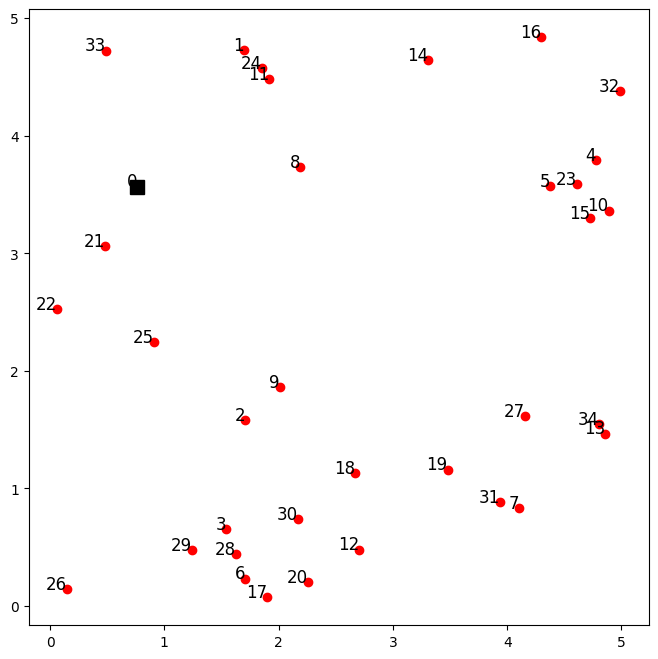

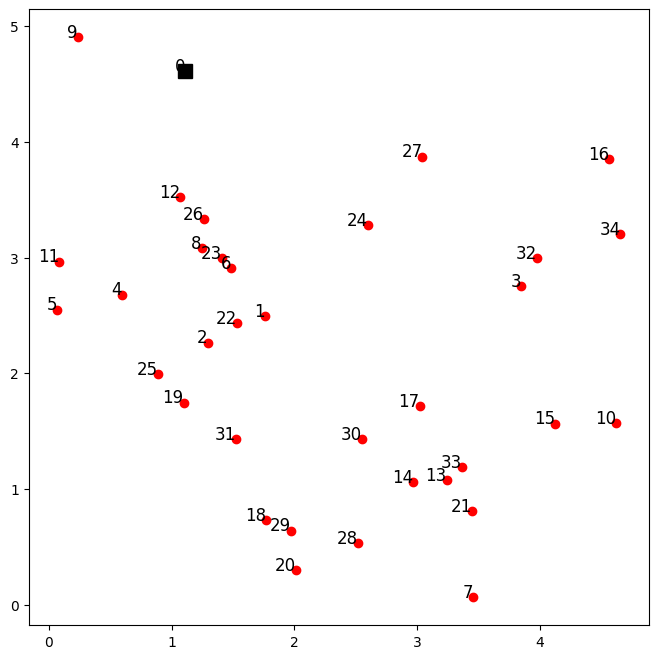

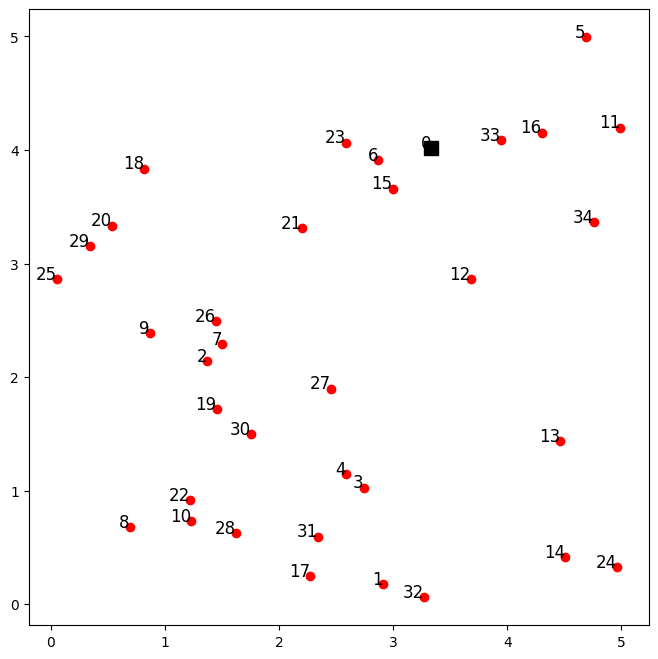

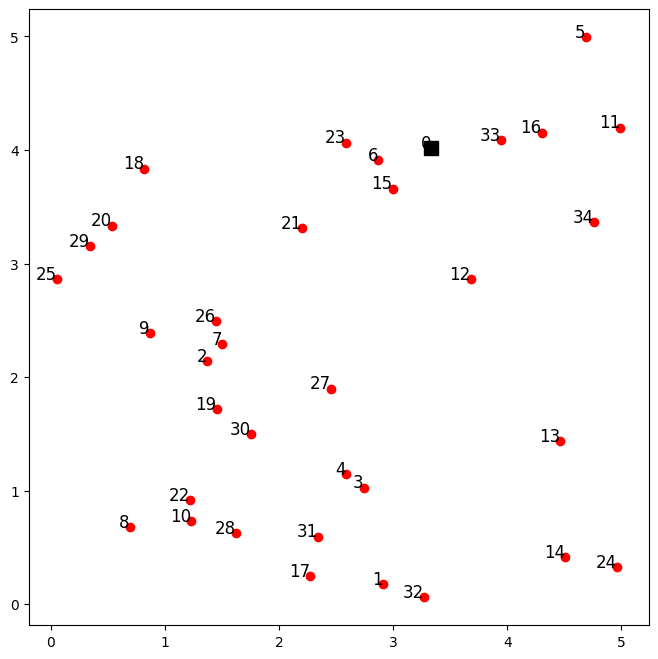

In [ ]:
import os
import json
import time

# Add your Open ai API key here
api_key = "API_KEY"
RES = {}

# Iterate over n and site
for n in range(10, 40, 5):
    for site in range(30):
        try:
            num_locations = n  # Number of locations (including the depot)
            num_salesmen = 1  # Number of salesmen, can also vary with site or n if needed

            # Generate MTSP data and get points and data dictionary
            points, data, solution_data = gen_mtsp(num_locations, num_salesmen, n, site)

            # Store the problem data under a unique key for each n and site
            RES[f'problem_{n}_{site}'] = data
            RES[f'solution_data_{n}_{site}'] = solution_data

            # Generate a problem statement for GPT
            problem_statement = generate_prompt(num_salesmen)

            # Querying GPT (simulated here as a function call)
            folder_path = '/content/drive/My Drive/MTSP_GPT'  # Change this to your desired file path
            image_path = os.path.join(folder_path, f'points_{n}_{site}.png')
            result = query_gpt(problem_statement, api_key, image_path, 0.0, 1)

            # Extract and save routes
            routes_dict = extract_and_save_routes(result)

            # Store routes data under a unique key for each n and site
            RES[f'routes_{n}_{site}'] = routes_dict

            # Plot MTSP routes (Assuming a function to plot given points and routes exists)
            routes_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_0.png'
            plot_mtsp_routes(points, routes_dict, routes_plot_filename)

            # Save the entire RES dictionary to a JSON file after the loops complete
            final_json_filename = '/content/drive/MyDrive/MTSP_GPT/final_results.json'
            with open(final_json_filename, 'w') as f:
                json.dump(RES, f, indent=4)

            for tr in range(10):
                try:
                    # Generate a problem statement for GPT
                    problem_statement2 = generate_prompt_2(num_salesmen)

                    image_path = f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_{tr}.png'
                    result = query_gpt(problem_statement2, api_key, image_path, 0.7, 7)
                    time.sleep(45)

                    # Extract and save routes
                    routes = extract_and_save_routes_for_score(result)

                    # Store routes data under a unique key for each n and site
                    RES[f'path_{n}_{site}_{tr}'] = routes

                    # Loop through each solution and plot
                    for solution_id, routes_dict in routes.items():
                        routes_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/sc_routes_{n}_{site}_{tr+1}_{solution_id}.png'
                        plot_mtsp_routes(points, routes_dict, routes_plot_filename)
                        print(f'Plot saved to {routes_plot_filename}')

                    Score_result = query_gpt_score(Score_prompt, api_key, 0.0, n, site, tr)
                    image_scores, best_route = extract_image_scores_and_best_route(Score_result)

                    RES[f'image_scores_{n}_{site}_{tr}'] = image_scores
                    RES[f'best_route_{n}_{site}_{tr}'] = best_route

                    selected_pair = select_kth_pair(routes, best_route - 1)

                    # Print the selected key-value pair
                    selected_routes_dict = selected_pair[1]
                    routes_plot_filename = f'/content/drive/MyDrive/MTSP_GPT/routes_{n}_{site}_{tr+1}.png'
                    plot_mtsp_routes(points, selected_routes_dict, routes_plot_filename)

                    # Save the entire RES dictionary to a JSON file after the loops complete
                    final_json_filename = '/content/drive/MyDrive/MTSP_GPT/final_results.json'
                    with open(final_json_filename, 'w') as f:
                        json.dump(RES, f, indent=4)

                except Exception as e:
                    print(f"An error occurred for n {n}, site {site}, iteration {tr}: {e}")
                    continue

        except Exception as e:
            print(f"An error occurred for site {site}: {e}")
            continue

print("All results saved to JSON file.")
